<a href="https://colab.research.google.com/github/salazarmaria/Notas-de-IA/blob/main/Accion_de_Amazon/Recurrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*_Valor de las acciones Amazon_*

Integrantes:


*   Luz Maria Salazar
*   Carlos Rivero Garduño



In [ ]:
import pandas as pd

_df = pd.read_csv("/content/Amazon_2021_2025.csv", delimiter=',') # Leemos el archivo CSV

# Ordenamos las filas de fecha que sea del mas antiguo al mas reciente
_df['Price'] = pd.to_datetime(_df['Price'], dayfirst=True, errors='coerce')
_df = _df.sort_values(by='Price', ascending=True).reset_index(drop=True)


_df.head() # Mostramos las primeras 5 filas como tabla

/tmp/ipython-input-1070049980.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _df['Price'] = pd.to_datetime(_df['Price'], dayfirst=True, errors='coerce')


,Price,Close,High,Low,Open,Volume
0,2021-01-04,159.3314972,163.6000061,157.201004,163.5,88228000
1,2021-01-05,160.9255066,161.1690063,158.253006,158.3005066,53110000
2,2021-01-06,156.9190063,159.8755035,156.5579987,157.3240051,87896000
3,2021-01-07,158.1080017,160.427002,157.75,157.8500061,70290000
4,2021-01-08,159.1349945,159.5319977,157.1100006,159,70754000


In [ ]:
# Seleccionar las columnas numéricas que se usarán para escalar y como entrada del modelo
df = _df[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

In [ ]:
# Seleccionar la columna 'Close' del dataframe original para escalar
dates = _df[['Close']].values

In [ ]:
# Convertimos la columna 'Close' del DataFrame original (_df) a valores numéricos;
# los valores no convertibles se reemplazan con NaN
_df['Close'] = pd.to_numeric(_df['Close'], errors='coerce')
# Eliminamos filas donde 'Close' quedó como NaN tras la conversión
_df.dropna(subset=['Close'], inplace=True)

# Convertimos la columna 'Close' del DataFrame usado para características a valores numéricos
# Eliminamos filas donde 'Close' no sea numérico en el DataFrame de características
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(subset=['Close'], inplace=True)

# Extraemos la columna 'Close' del DataFrame de características (df) como matriz para su posterior escalado
dates = df[['Close']].values

In [ ]:
# Importamos MinMaxScaler, que sirve para escalar valores numéricos a un rango específico
from sklearn.preprocessing import MinMaxScaler

# Inicializamos el escalador MinMax para transformar los valores al rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
# Ajustamos el escalador a los datos de 'Close' y transformamos los valores
scaled_data = scaler.fit_transform(dates)

In [ ]:
# en esta celda definimos el tamaño de nuestra ventana que son los dias que se tomaran hacia atras
# tomaremos como ventana de 30 días anteriores para poder predecir el siguiente valor
window_size = 30

In [ ]:
# Importamos NumPy, que se usa para manejar arreglos numéricos de manera eficiente
import numpy as np

# Función para crear secuencias que serán usadas como entrada del modelo
def create_sequences(data, window_size):
    sequences = []  # Aquí guardamos las ventanas de datos
    labels = [] # Aquí guardamos el valor que el modelo debe predecir
    # Recorremos el dataset creando una ventana de tamaño 'window_size' en cada paso
    for i in range(len(data) - window_size):
              # Agregamos una secuencia de 'window_size' valores
        sequences.append(data[i:i+window_size])
        # El precio es la primera columna
        labels.append(data[i + window_size, 0])
         # Convertimos listas a arreglos NumPy para que el modelo pueda procesarlos
    return np.array(sequences), np.array(labels)

# Crear las secuencias y las etiquetas a partir de los datos escalados
X, y = create_sequences(scaled_data, window_size)

In [ ]:
# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]  # Datos para entrenar el modelo
X_test, y_test = X[split:], y[split:] # Datos para evaluar el modelo
# divido los datos en dos partes que son el 80% lo uso para entrenar el modelo (X_train, y_train) y el 20% restante para probarlo (X_test, y_test)
# ya que sirve para que el modelo aprenda con una parte de los datos y luego pueda evaluarse con otros que no ha visto antes
#y asi poder comprobar si realmente funciona

In [ ]:
# Importamos módulos necesarios para construir el modelo RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN

# Construir el modelo RNN
model = Sequential()
# Añadir una capa SimpleRNN con 120 unidades, que devuelve secuencias
model.add(SimpleRNN(units=120, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
# Añadir otra capa SimpleRNN con 60 unidades, que no devuelve secuencias
model.add(SimpleRNN(units=60, return_sequences=False))
# Añadir una capa densa con 30 unidades
model.add(Dense(units=30))
# Añadir una capa de salida densa con 1 unidad para la predicción
model.add(Dense(units=1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Importamos el optimizador Adam
from tensorflow.keras.optimizers import Adam

# Definir la tasa de aprendizaje para el optimizador Adam
learning_rate = 0.0001
adam_optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo con el optimizador Adam y la función de pérdida de error cuadrático medio que se usa comúnmente en regresión
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Entrenar el modelo
# Mientras más se acerque el valor a 0, quiere decir  que el modelo está aprendiendo
# porque está cometiendo menos errores al comparar las predicciones con los datos reales
# pero si el valor se mantiene alto o no bajo nos indica que el modelo no está aprendiendo correctamente
model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0132
Epoch 2/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0016
Epoch 3/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0011
Epoch 4/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0011
Epoch 5/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0010
Epoch 6/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.1993e-04
Epoch 7/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.4244e-04
Epoch 8/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.8578e-04
Epoch 9/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.4610e-04
Epoch 10/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.3023e-04
Epoch 11/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.2510e-04
Epoch 12/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.2990e-04
Epoch 13/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.7792e-04
Epoch 14/30
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.7519e-04
Epoch 15/30
951/951 ━

In [ ]:
# Hacer predicciones  #trata de adivinar el precio futuro de Amazon según los patrones que aprendió durante el entrenamiento
predictions = model.predict(X_test)

# Desescalar los datos predichos
# Las predicciones están escaladas entre 0 y 1, necesitamos devolverlas a su escala original
# Para desescalar, necesitamos un array con la misma forma que los datos originales de escalado
# Concatenamos las predicciones con ceros para que coincidan con la forma de 'dates' (que tiene 4 columnas)
# Luego desescalamos y seleccionamos solo la primera columna (la de precios)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:,0] #son los precios que el modelo predijo

# Desescalar los valores reales de prueba
# Hacemos lo mismo para los valores reales de prueba para poder compararlos con las predicciones desescaladas
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:,0] #son los precios reales de Amazon

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


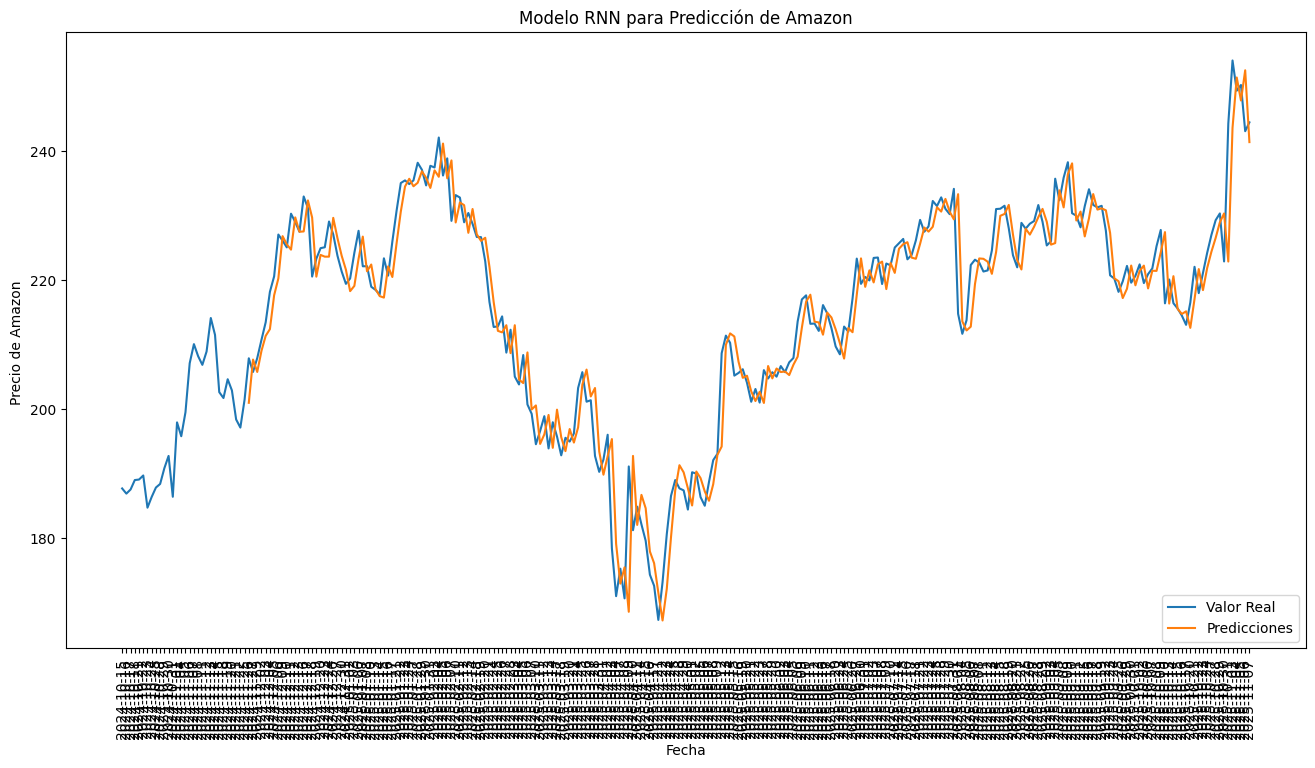

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Seleccionar la parte de los datos para validación (conjunto de prueba)
valid = _df[split:]
# Reiniciar el índice del DataFrame de validación para asegurar que coincida con las predicciones
valid = valid.reset_index(drop=True)
# Creamos una columna vacía donde colocaremos las predicciones (NaN indica sin valor)
valid['Predictions'] = np.nan

# Añadir las predicciones desescaladas al DataFrame de validación
# Las predicciones corresponden a los datos de prueba, que empiezan después del tamaño de la ventana
valid.loc[window_size:, 'Predictions'] = predictions

# Usamos la columna 'Price' como fecha
# Convertir la columna 'Price' a formato datetime y luego a formato de cadena YYYY-MM-DD
dates_valid = pd.to_datetime(valid['Price']).apply(lambda x: x.strftime('%Y-%m-%d')).tolist()

# Crear el gráfico para visualizar los resultados
plt.figure(figsize=(16,8)) # Definir el tamaño de la figura
plt.title('Modelo RNN para Predicción de Amazon') # Título del gráfico
plt.xlabel('Fecha') # Etiqueta del eje X
plt.ylabel('Precio de Amazon ') # Etiqueta del eje Y
# Graficar los valores reales ('Close') y las predicciones
plt.plot(dates_valid, valid[['Close', 'Predictions']])
plt.legend(['Valor Real', 'Predicciones'], loc='lower right') # Mostrar leyenda
plt.xticks(rotation=90) # Rotar las etiquetas del eje X para mejor legibilidad
plt.show() # Mostrar el gráfico

In [ ]:
# Creamos una lista vacía para guardar las secuencias futuras
future_sequences = []
# Última secuencia de los valores que tenemos en el conjunto de entrenamiento/prueba
last_sequence = X[-1]

days = 10 # Número de días que queremos predecir
for _ in range(days):
    # El modelo predice el siguiente valor a partir de la última secuencia conocida
    next_value = model.predict(np.array([last_sequence]))[0, 0]

    # Actualizar la secuencia para la siguiente predicción
    # Eliminar el primer elemento y añadir el valor predicho al final
    last_sequence = np.concatenate((last_sequence[1:], [[next_value]]), axis=0)

    # Añadir la nueva secuencia a la lista de secuencias futuras
    future_sequences.append(last_sequence)

# Convertir la lista de secuencias futuras a un array de numpy
future_sequences = np.array(future_sequences)
# Ajustamos la forma de las secuencias al formato requerido por el modelo RNN
future_sequences = np.reshape(future_sequences, (future_sequences.shape[0], future_sequences.shape[1], 1))

# Hacer predicciones para los siguientes días usando el modelo entrenado
future_predictions = model.predict(future_sequences)

# Desescalar los datos predichos para los siguientes días
# Hacemos lo mismo que antes para devolver las predicciones futuras a su escala original
future_predictions = scaler.inverse_transform(np.concatenate((future_predictions, np.zeros((future_predictions.shape[0], 4))), axis=1))[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [ ]:
# Última fecha en los datos reales (la última fecha en el conjunto de prueba)
last_date = _df['Price'].iloc[-1]
# Generar un rango de fechas futuras comenzando desde la última fecha real
# Excluimos la primera fecha ya que es la última fecha real
future_dates = pd.date_range(start=last_date, periods=days + 1)[1:]
# Formatear las fechas futuras a AAAA-MM-DD y convertirlas a una lista
future_dates = future_dates.strftime('%Y-%m-%d').tolist()

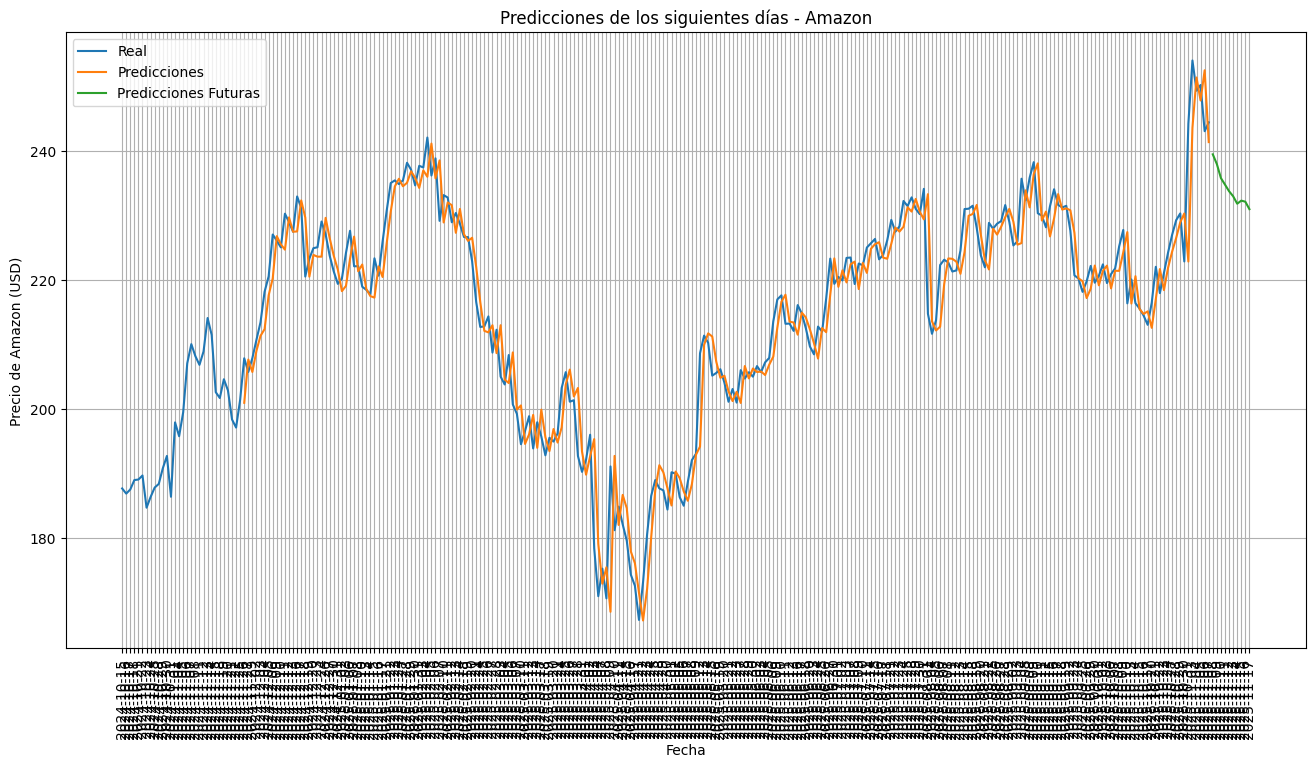

In [ ]:
# Crear el gráfico para visualizar las predicciones futuras
plt.figure(figsize=(16,8)) # Definir el tamaño de la figura
plt.title('Predicciones de los siguientes días - Amazon') # Título del gráfico
plt.xlabel('Fecha') # Etiqueta del eje X
plt.ylabel('Precio de Amazon (USD)') # Etiqueta del eje Y
# Graficar los valores reales y las predicciones históricas del conjunto de prueba
plt.plot(dates_valid, valid[['Close', 'Predictions']], label=['Real', 'Predicciones'])
# Graficar las predicciones futuras
# Usamos [:-1] en future_predictions porque generamos 'days' predicciones, pero range() generó 'days + 1' fechas.
# Si tenemos 10 días de predicción, queremos 10 puntos de datos, no 11 fechas.
plt.plot(future_dates, future_predictions, label='Predicciones Futuras')
plt.legend() # Mostrar leyenda
plt.xticks(rotation=90) # Rotar las etiquetas del eje X
plt.grid(True) # Cuadricula el grafico
plt.show() # Mostrar el gráfico